# Notebook of Model Training for Potato Image Classification

The data can be found at: https://www.kaggle.com/datasets/arjuntejaswi/plant-village

In this notebook, we will process the data, split it into training and test sets and then build a CNN model for performing the classification predictions.

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers

import matplotlib.pyplot as plt

2024-01-10 18:56:53.968431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 18:56:55.674954: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# define the image size and the batch size
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 35

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


2024-01-10 18:56:58.737162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-10 18:56:58.871214: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset) 
# it shows length 68 because we have divided our data into batches of 32. therefore we get 68 such batches

68

2024-01-10 18:56:59.025560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-01-10 18:56:59.026652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]
	 [[{{node Placeholder/_0}}]]


2024-01-10 18:56:59.195971: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.


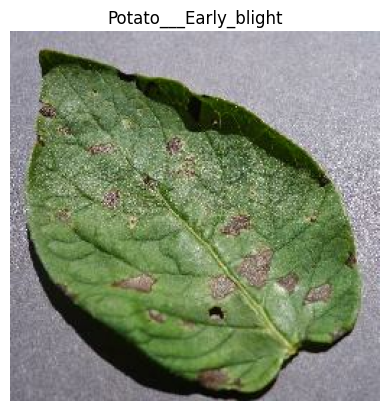

In [6]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.axis('off')
    plt.title(class_names[label_batch[0]])
    plt.show()

2024-01-10 18:56:59.519044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-01-10 18:56:59.519982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-01-10 18:56:59.670556: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.


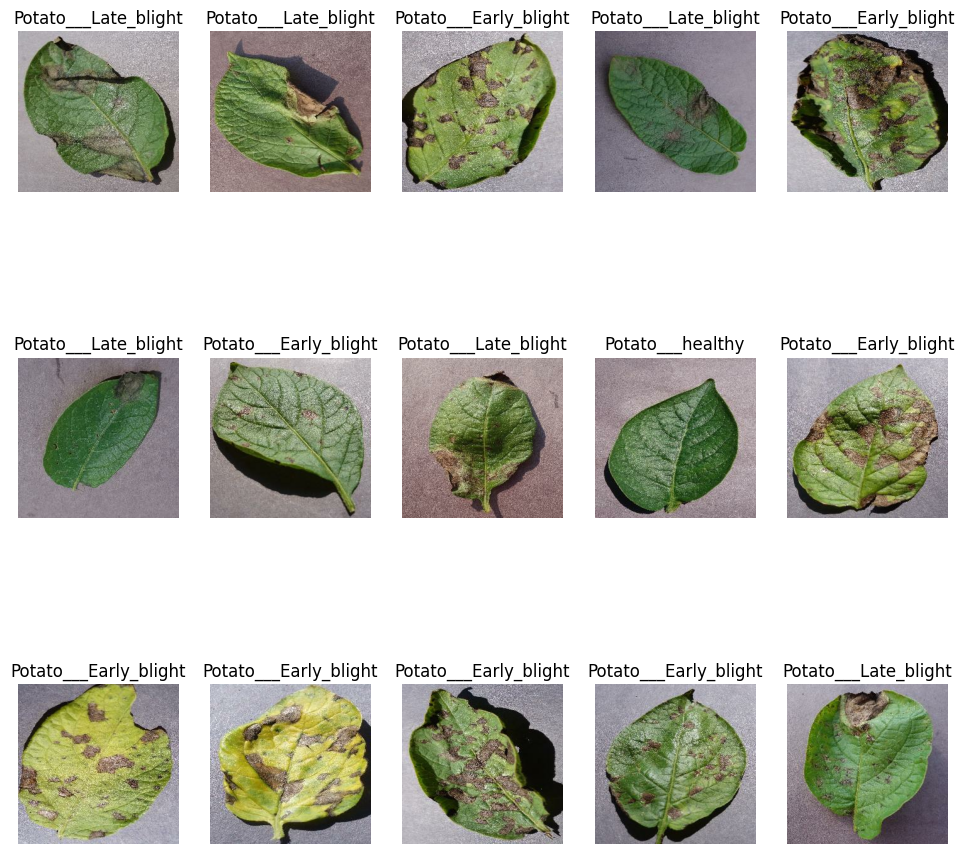

In [7]:
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

For Train Test Split, we will do a split of 80-20 where 80 percent will be our training set, and 20 percent will be testing and validation set.

We keep 10 percent for validation set and last 10 percent for testing. The validation set will be used while model training to find the model's performance, whereas the test set, we will use once our model is built.

In [8]:
# In sklearn we have train-test split. But we don't have that here. Hence we'll use dataset.take()
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
# TRAIN DATASET
train_dataset = dataset.take(54)
len(train_dataset)

54

In [10]:
remaining = dataset.skip(54)
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [11]:
# VALIDATION DATASET
val_dataset = remaining.take(6)
len(val_dataset)

6

In [12]:
# TEST DATASET
test_ds = remaining.skip(6)
len(test_ds)

8

In [13]:
# Lets create a nice python function to do the train test split that we did above
def create_train_test_split(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(dataset)

    if shuffle:
        ds = dataset.shuffle(shuffle_size,seed=42)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = dataset.take(train_size)

    val_ds = dataset.skip(train_size).take(val_size)

    test_ds = dataset.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [14]:
train_ds,val_ds,test_ds = create_train_test_split(dataset)

In [15]:
len(test_ds)

8

In [16]:
len(train_ds)

54

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


# This will help in better performance as the images will be stored in cache and we don't have to load them again and again

In [18]:
# Preprocessing our images and apply augmentation
resize_rescale = tf.keras.Sequential(
    [   
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
        layers.experimental.preprocessing.Rescaling(1.0/255) 
    ]
)
# our images are already 256x256, so why are we resizing in the pipeline. This is because during prediction if our 
# image is not 256x256 it will cause problems. Hence we are resizing them beforehand so that all the images are of same size

# generally our images are in range of 0 to 255. using resclaing, we scale their values between 0 and 1

In [19]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.3),
        layers.experimental.preprocessing.RandomContrast(factor=(0.5, 1.5))


    ]
)

# Model Training

In [20]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model = models.Sequential(
    [
        resize_rescale,
        data_augmentation,
        layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(64,activation='relu'),
        layers.Dense(n_classes,activation='softmax')

    ]  
)
model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [22]:
# compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
# training the model(fitting it to our data)

with tf.device('/gpu:0'): # only run with this if you have gpu device available. else just remove the with statement and the later indentation.
    history = model.fit(
        train_ds,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        verbose=1,
        validation_data = val_ds
    )

Epoch 1/35
54/54 [==============================] - ETA: 0s - loss: 0.7748 - accuracy: 0.6516

2024-01-10 19:00:26.685106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-01-10 19:00:26.686465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


54/54 [==============================] - 149s 3s/step - loss: 0.7748 - accuracy: 0.6516 - val_loss: 0.7195 - val_accuracy: 0.6927
Epoch 2/35
54/54 [==============================] - 145s 3s/step - loss: 0.4857 - accuracy: 0.7905 - val_loss: 0.5143 - val_accuracy: 0.8021
Epoch 3/35
54/54 [==============================] - 157s 3s/step - loss: 0.4110 - accuracy: 0.8223 - val_loss: 0.3978 - val_accuracy: 0.8073
Epoch 4/35
54/54 [==============================] - 164s 3s/step - loss: 0.3077 - accuracy: 0.8698 - val_loss: 0.2721 - val_accuracy: 0.9062
Epoch 5/35
54/54 [==============================] - 175s 3s/step - loss: 0.2932 - accuracy: 0.8854 - val_loss: 0.2452 - val_accuracy: 0.9062
Epoch 6/35
54/54 [==============================] - 168s 3s/step - loss: 0.2573 - accuracy: 0.8981 - val_loss: 0.2344 - val_accuracy: 0.9115
Epoch 7/35
54/54 [==============================] - 152s 3s/step - loss: 0.2567 - accuracy: 0.8981 - val_loss: 0.3206 - val_accuracy: 0.8646
Epoch 8/35
54/54 [======

In [25]:
scores = model.evaluate(test_ds)

2024-01-10 20:23:24.327013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-01-10 20:23:24.328255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]
	 [[{{node Placeholder/_0}}]]


6/6 [==============================] - 3s 493ms/step - loss: 0.0250 - accuracy: 0.9896


## Plotting Model History

In [26]:
history.params

{'verbose': 1, 'epochs': 35, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
history.history['accuracy']

[0.6516203880310059,
 0.7905092835426331,
 0.8223379850387573,
 0.8697916865348816,
 0.8854166865348816,
 0.8981481194496155,
 0.8981481194496155,
 0.8998842835426331,
 0.9288194179534912,
 0.9461805820465088,
 0.9328703880310059,
 0.9392361044883728,
 0.9415509104728699,
 0.9409722089767456,
 0.9386574029922485,
 0.9594907164573669,
 0.9508101940155029,
 0.9594907164573669,
 0.9571759104728699,
 0.9380787014961243,
 0.9699074029922485,
 0.9745370149612427,
 0.9577546119689941,
 0.9641203880310059,
 0.9797453880310059,
 0.9745370149612427,
 0.9756944179534912,
 0.9716435074806213,
 0.9751157164573669,
 0.9681712985038757,
 0.9791666865348816,
 0.9768518805503845,
 0.9797453880310059,
 0.9780092835426331,
 0.9756944179534912]

In [29]:
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


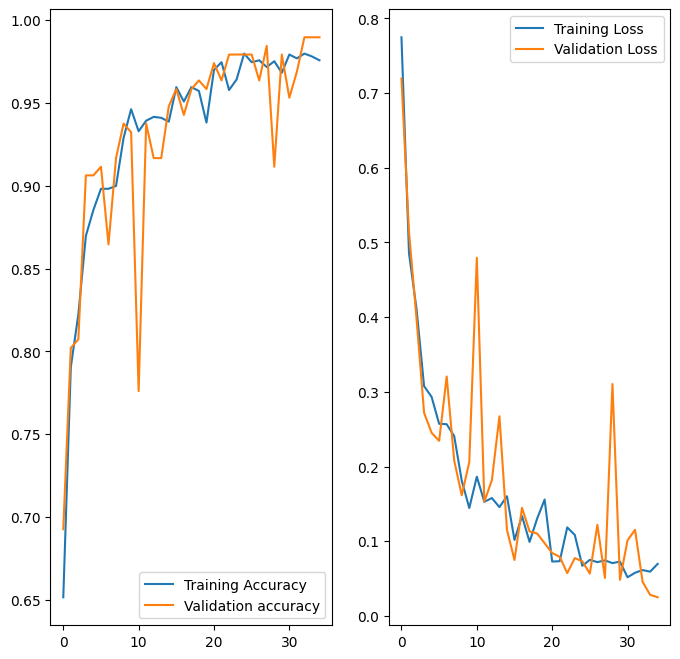

In [30]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_accuracy,label='Validation accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend()

# Making Predictions on sample image

2024-01-10 20:23:58.282600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-01-10 20:23:58.283304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


Actual Label:  Potato___Early_blight
1/1 [==============================] - 1s 560ms/step
Predicted Label:  Potato___Early_blight


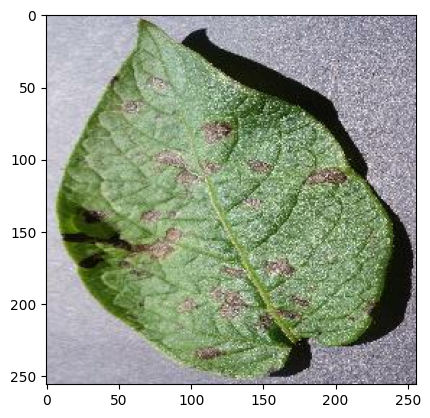

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    plt.imshow(first_image)
    print("Actual Label: ",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [33]:
# Creating a function that takes the model and image as input and that tells us the predicted class
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy)
    img_array = tf.expand_dims(img_array,0) # creates a batch

    predictions=model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.argmax(predictions[0])),2)

    return predicted_class,confidence

# Saving the model

In [35]:
model_version=2
model.save(f"models/{model_version}")

2024-01-10 20:24:19.922374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [?,256,256,3]
	 [[{{node random_flip_input}}]]
2024-01-10 20:24:20.079825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256,256,3]
	 [[{{node inputs}}]]
2024-01-10 20:24:20.102474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [

INFO:tensorflow:Assets written to: models/2/assets


INFO:tensorflow:Assets written to: models/2/assets
